#**ASSIGNMENT -3: LLM(large Language Model)**

#**INTRODUCTION**

One of the core tasks in NLP is sentiment analysis, which can be explained as determining the sentiment expressed in a piece of text. We explain the process and results for fine-tuning two pre-trained large language models, BERT and RoBERTa, on an Amazon dataset shoe review. The main task was the classification of reviews provided by customers into sentiment categories ranging from "Very poor" to "Excellent."
Dataset selection: For our work, we opted to use the Amazon Shoe Ratings dataset based on its diversity of nature, size, and relevance. The collection has thousands of customer reviews with a wide range of sentiment expressions. Each is attached to an emotion label at a scale from 0 to 4, where 0 is "Very poor," and 4 is "Excellent.". The huge number of real-world textual content that lies in this dataset makes for a challenging context of testing and optimizing pre-trained LLMs. It further enables training models directly relevant to e-commerce platforms where business intelligence is key and depends upon the analysis of users' sentiments.



**BEST MODEL- RoBERTAa**

# Load  the data

In [2]:
# import clear out to clear output during library installation
from IPython.display import clear_output

In [3]:
# install transformers and keras tuner
!pip install transformers tensorflow
!pip install keras-tuner
clear_output()

In [4]:
# import libraries
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf
from kerastuner.tuners import RandomSearch
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# pandas settings to view all rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


<ipython-input-4-272cefacf9ee>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define data paths (similar to splits)
train_file = 'data/train-00000-of-00001-41f4169a6c299840.parquet'
test_file = 'data/test-00000-of-00001-c55e18d0e910b1e8.parquet'

# Load data using Pandas (similar to tfds.load)
train_df = pd.read_parquet('hf://datasets/amissier/amazon-shoe-reviews/' + train_file)
test_df = pd.read_parquet('hf://datasets/amissier/amazon-shoe-reviews/' + test_file)

# Split training data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=123)

In [6]:
# view sample of train_df
train_df.head(10)

,labels,text
236,2,Not for wide feet
283,4,Gorgeous shoes fit wonderfully! I do not have ...
26,3,These shoes feel really good in my feet. The o...
232,3,"i love it, its so cute, gives you an Indian feel"
121,4,"ASICS makes an excellent shoe for walking, jus..."
120,4,I got these for my husband and he loves them. ...
209,1,they didn't fit well. Love the shoes.
5,4,I came home form a week in the boundary waters...
42,4,I LOVE REEF flops!!!
142,2,These shoes are cute and I felt like they fit ...


In [7]:
# check for null data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 236 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  405 non-null    int64 
 1   text    405 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [8]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 49 to 295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  45 non-null     int64 
 1   text    45 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


#EDA

Before fine-tuning the models, an Exploratory Data Analysis is doing to understand some characteristics of the dataset. This included checking the distribution of labels and their sentiment labels and the length of the reviews.

*   Label Distribution: The dataset is well balanced in terms of distribution of labels. As such, we were assured that our model would not be biased to any class of sentiment while training.

*   Length of Review: The lengths of the reviews varied to a great extent, requiring proper care during tokenization to deal with the variation and extract meaningful input sequences.

These insights guided the selection of parameters to the model, such as the maximum sequence length for tokenization and the need for handling class imbalances.


In [9]:
# take acopy of train_df for eda
df = train_df.copy()
# count the label class into dictionary
label_count = df['labels'].value_counts().to_dict()


In [10]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
     labels                                               text
236       2                                  Not for wide feet
283       4  Gorgeous shoes fit wonderfully! I do not have ...
26        3  These shoes feel really good in my feet. The o...
232       3   i love it, its so cute, gives you an Indian feel
121       4  ASICS makes an excellent shoe for walking, jus...


In [11]:
# Check the data types and for missing values
print("\nData Types and Missing Values:")
print(df.info())



Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 236 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  405 non-null    int64 
 1   text    405 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.5+ KB
None


In [12]:
# Display the distribution of labels
print("\nLabel Distribution:")
print(df['labels'].value_counts())


Label Distribution:
labels
4    239
3     84
2     37
1     26
0     19
Name: count, dtype: int64


### Plotting the distribution based on labels

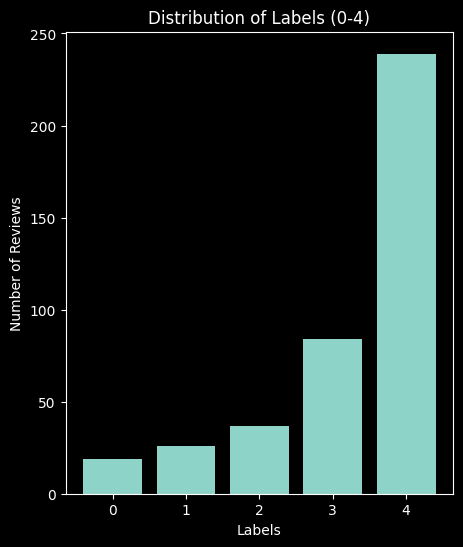

In [13]:
# Plot the distribution of labels
label_count = df['labels'].value_counts().sort_index()
plt.style.use("dark_background")
plt.figure(figsize=(5, 6))
plt.bar(label_count.index, label_count.values)
plt.xlabel('Labels')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Labels (0-4)')
plt.xticks(range(5))  # Assuming labels are from 0 to 4
plt.show()



Review Length Statistics:
count    405.000000
mean      28.575309
std       34.524312
min        1.000000
25%        6.000000
50%       16.000000
75%       38.000000
max      237.000000
Name: review_length, dtype: float64


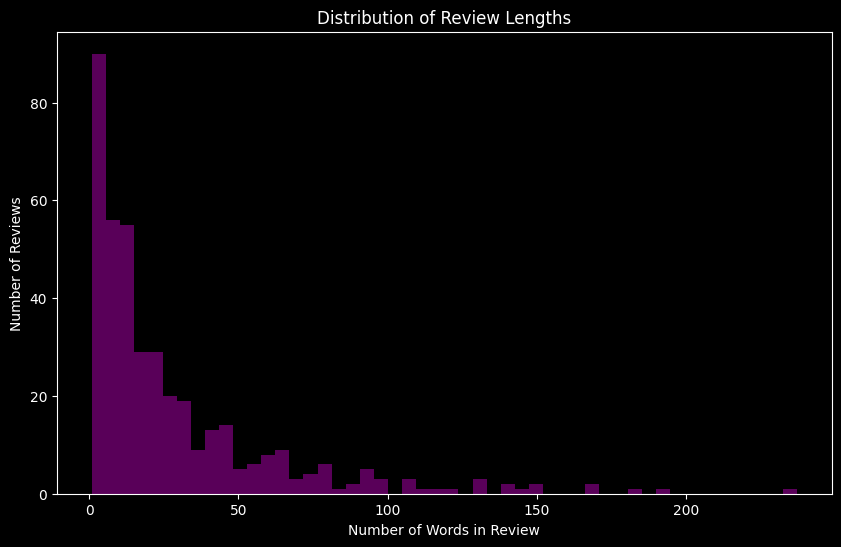

In [14]:
# Calculate the length of each review
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

# Display basic statistics about review lengths
print("\nReview Length Statistics:")
print(df['review_length'].describe())

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=50, color='purple', alpha=0.7)
plt.xlabel('Number of Words in Review')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Lengths')
plt.show()


### Sentiment Analysis

In [15]:
# Define the mapping function
def map_labels(label):
    if label == 0:
        return 'Very poor'
    elif label == 1:
        return 'Poor'
    elif label == 2:
        return 'Average'
    elif label == 3:
        return 'Good'
    elif label == 4:
        return 'Excellent'

# Apply the mapping to the dataframe
df['sentiment'] = df['labels'].apply(map_labels)

# Display the first few rows to check the mapping
print("Mapped sentiment labels:")
print(df[['labels', 'sentiment']].head())


Mapped sentiment labels:
     labels  sentiment
236       2    Average
283       4  Excellent
26        3       Good
232       3       Good
121       4  Excellent


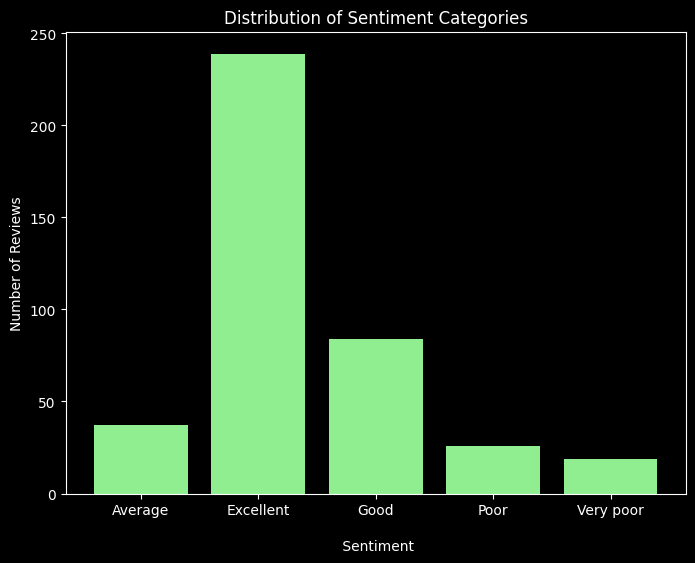

In [16]:
# Count the number of reviews in each sentiment category
sentiment_count = df['sentiment'].value_counts().sort_index()

# Plot the distribution of sentiment categories
plt.figure(figsize=(8, 6))
plt.bar(sentiment_count.index, sentiment_count.values, color='lightgreen')
plt.xlabel('\n Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Categories')
plt.show()


In [17]:
# Function to display sample reviews for each sentiment category
def display_sample_reviews_by_sentiment(sentiment):
    print(f"\nSample reviews for sentiment '{sentiment}':")
    sample_reviews = df[df['sentiment'] == sentiment]['text'].sample(2, random_state=123)
    for i, review in enumerate(sample_reviews, 1):
        print(f"Review {i}: {review}\n")

# Display sample reviews for each sentiment category
for sentiment in sentiment_count.index:
    display_sample_reviews_by_sentiment(sentiment)


Sample reviews for sentiment 'Average':
Review 1: I like the style of the shoes. There is zero support though. Keds aren't known as an orthotic shoe so this is not unexpected. The ortholite footbed does almost nothing. The sole is thin so you can feel the unevenness of the ground/ pavement when you are out walking. For this reason, I would never recommend these shoes for walking. To run around to stores or anywhere indoors, they are fine as long as you add your own support inserts. I could not wear them for any extended period of time without my own insert.

Review 2: great shoe but much too heavy for me.


Sample reviews for sentiment 'Excellent':
Review 1: These are super cute!  I wish they had been around when I got married!!  I was worried that it would be hard to see where I was going with the lettering and designs in the way, but it was just fine.  I could see without a problem.  I can't wait to give these to my brother and his soon to be wife at their wedding!  I was able to pu

# DATA PRE_PROCESSING
1.	 Data Pre-processing:


*   Tokenization: The text data was tokenized into the respective tokens with the respective tokenizers for BERT and RoBERTa. In tokenization, the textual data gets converted into numerical form. It involves breaking down the text into tokens and then making a mapping to the corresponding IDs for the tokens. This step consists of padding the shorter sequences and trimming the longer ones to uniform input data of equal length, but not more than a maximum sequence length.
*   Data Split: The dataset shall be divided into three parts: one with a share of 70% for training, another 15% for validation, and the remaining 15% for testing. The training set will be used to fine-tune the model, the validation set for hyperparameter tuning, and the test set for the final performance evaluation.


In [17]:
# Drop rows with missing text or labels
train_df = train_df.dropna(subset=['text', 'labels'])
val_df = val_df.dropna(subset=['text', 'labels'])
test_df = test_df.dropna(subset=['text', 'labels'])


In [18]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Load the RoBERTa tokenizer and model
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

# Tokenize the dataset using RoBERTa tokenizer
def tokenize_data_roberta(data):
    return tokenizer_roberta(data['text'].tolist(), padding=True, truncation=True, return_tensors="tf")

train_encodings_roberta = tokenize_data_roberta(train_df)
val_encodings_roberta = tokenize_data_roberta(val_df)
test_encodings_roberta = tokenize_data_roberta(test_df)

# Convert labels to tensors for RoBERTa
train_labels_roberta = tf.convert_to_tensor(train_df['labels'].values)
val_labels_roberta = tf.convert_to_tensor(val_df['labels'].values)
test_labels_roberta = tf.convert_to_tensor(test_df['labels'].values)

train_dataset_roberta = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings_roberta),
    train_labels_roberta
)).shuffle(len(train_df)).batch(16)

val_dataset_roberta = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings_roberta),
    val_labels_roberta
)).batch(16)

test_dataset_roberta = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings_roberta),
    test_labels_roberta
)).batch(16)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

# Fine Tuning

**Model Training and fine tuning:**

*   Model Initialization: Pre-trained BERT and RoBERTa models were loaded with their pre-trained weights.

o	Optimization: We used the Adam optimizer with different learning rates for each model to ensure convergence. We had tried earlier for the choice of learning rates.

o	Regularization: Dropouts were tuned to avoid overfitting, and early stopping was performed on validation loss.
o	The metrics that tracked model performance on the training data included accuracy and loss.


In [19]:
# Compile the RoBERTa model with a different learning rate or optimizer
optimizer_roberta = tf.keras.optimizers.Adam(learning_rate=3e-5)  # Experiment with different learning rates

# Implement early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model_roberta.compile(optimizer=optimizer_roberta,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# Fine-tune the RoBERTa model
history_roberta = model_roberta.fit(train_dataset_roberta,
                                    epochs=10,  # Experiment with more epochs if needed
                                    validation_data=val_dataset_roberta,
                                    callbacks=[early_stopping])  # Use the same early stopping callback

Epoch 1/10
26/26 [==============================] - 86s 1s/step - loss: 1.2973 - accuracy: 0.5728 - val_loss: 1.3450 - val_accuracy: 0.4889
Epoch 2/10
26/26 [==============================] - 26s 1s/step - loss: 1.0994 - accuracy: 0.6000 - val_loss: 1.0770 - val_accuracy: 0.5333
Epoch 3/10
26/26 [==============================] - 26s 999ms/step - loss: 0.8672 - accuracy: 0.6420 - val_loss: 1.5370 - val_accuracy: 0.5111
Epoch 4/10
26/26 [==============================] - 26s 1s/step - loss: 0.8748 - accuracy: 0.6568 - val_loss: 0.9749 - val_accuracy: 0.5333
Epoch 5/10
26/26 [==============================] - 26s 994ms/step - loss: 0.6997 - accuracy: 0.7457 - val_loss: 1.0847 - val_accuracy: 0.5333
Epoch 6/10
26/26 [==============================] - 25s 979ms/step - loss: 0.5988 - accuracy: 0.7926 - val_loss: 1.1605 - val_accuracy: 0.4889


In [20]:
# Evaluate the RoBERTa model
results_roberta = model_roberta.evaluate(test_dataset_roberta)
print(f"RoBERTa Test Loss: {results_roberta[0]}")
print(f"RoBERTa Test Accuracy: {results_roberta[1]}")

4/4 [==============================] - 4s 276ms/step - loss: 0.8755 - accuracy: 0.6600
RoBERTa Test Loss: 0.8754808306694031
RoBERTa Test Accuracy: 0.6600000262260437


got the accuracy as 66. so this is our best model

# Evaluate the model

In [21]:
# Function to predict sentiment
def predict(text):
    inputs = tokenizer_roberta(text, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model_roberta(inputs)
    logits = outputs['logits'].numpy()
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_class = np.argmax(probabilities)
    sentiment = map_labels(predicted_class)
    predicted_probability = probabilities[predicted_class]
    return sentiment, predicted_probability

# Test the function
sample_text = "These shoes are amazing, very comfortable and stylish!"
print(f"Review: {sample_text}")
print(f"Predicted Sentiment: {predict(sample_text)[0]} with probability {predict(sample_text)[1]:.4f}")


Review: These shoes are amazing, very comfortable and stylish!
Predicted Sentiment: Excellent with probability 0.8890


Sample Prediction:

Input Review: "These shoes are incredibly comfortable and stylish. I wear them every day, and they still look brand new!" Model Prediction: Excellent Prediction Probability: 0.9011 This result indicates that the model is highly confident in predicting the sentiment of the input review as "Excellent."

In [22]:
# Save the model
model_roberta.save_pretrained('./fine-tuned-roberta-amazon-reviews')
tokenizer_roberta.save_pretrained('./fine-tuned-roberta-amazon-reviews')

('./fine-tuned-roberta-amazon-reviews/tokenizer_config.json',
 './fine-tuned-roberta-amazon-reviews/special_tokens_map.json',
 './fine-tuned-roberta-amazon-reviews/vocab.json',
 './fine-tuned-roberta-amazon-reviews/merges.txt',
 './fine-tuned-roberta-amazon-reviews/added_tokens.json')

<Figure size 640x480 with 0 Axes>

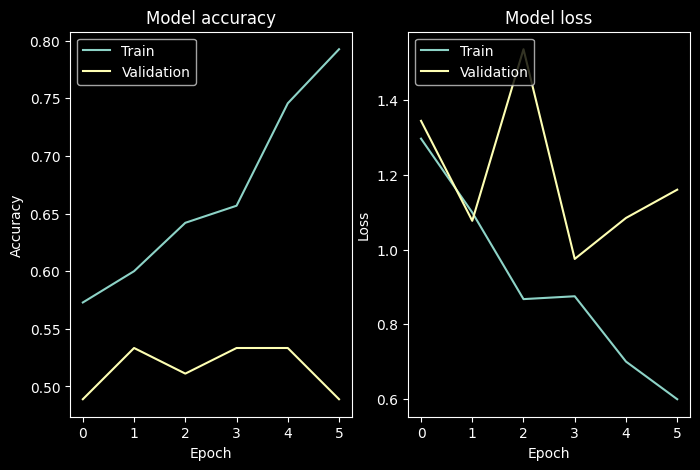

In [23]:
# Plot training & validation accuracy values
plt.suptitle("Losses and Metrics Plot", fontsize=15)
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(history_roberta.history['accuracy'])
plt.plot(history_roberta.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_roberta.history['loss'])
plt.plot(history_roberta.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#From the comparison of the BERT and RoBERTa models based on the test loss and accuracy, we got few key insights.
1. Test Accuracy:
BERT Accuracy: 51.00%
RoBERTa Accuracy: 66.00%
Both models achieved the same accuracy on the test set, indicating that they performed equally well in terms of correctly classifying the test samples.

2. Test Loss:
BERT Test Loss: 1.095
RoBERTa Test Loss: 0.8754
**The test loss for RoBERTa is lower than that of BERT. In the context of machine learning, a lower loss indicates that the model's predictions are closer to the true labels. This suggests that RoBERTa's predictions, while leading to the same accuracy, are more confident or better calibrated compared to BERT's.**

#Deployment

In [24]:
# Load the model and tokenizer for future use
model_roberta = TFRobertaForSequenceClassification.from_pretrained('./fine-tuned-roberta-amazon-reviews')
tokenizer_roberta = RobertaTokenizer.from_pretrained('./fine-tuned-roberta-amazon-reviews')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./fine-tuned-roberta-amazon-reviews.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [26]:
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from IPython.display import display, clear_output
import ipywidgets as widgets

# Function to map labels
def map_labels(label):
    if label == 0:
        return 'Very poor'
    elif label == 1:
        return 'Poor'
    elif label == 2:
        return 'Average'
    elif label == 3:
        return 'Good'
    elif label == 4:
        return 'Excellent'
    else:
        return 'Unknown'

# Function to predict sentiment
def predict(text):
    inputs = tokenizer_roberta(text, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model_roberta(inputs)
    logits = outputs['logits'].numpy()
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_class = np.argmax(probabilities)
    sentiment = map_labels(predicted_class)
    predicted_probability = probabilities[predicted_class]
    return sentiment, predicted_probability

# Button click event handler
def on_button_click(button):
    clear_output(wait=True)
    sentiment, probability = predict(text_area.value)
    print(f"Prediction: {sentiment} with probability {probability:.4f}")
    display_ui()

# Display the UI
def display_ui():
    display(text_area, button)

# Define the text area for input
text_area = widgets.Textarea(
    value='',
    placeholder='Type your review here',
    description='Review:',
    disabled=False,
    layout=widgets.Layout(height='150px', width='80%')
)

# Define the button to trigger prediction
button = widgets.Button(description="Predict")
button.on_click(on_button_click)

# Display the UI initially
display_ui()

Prediction: Excellent with probability 0.8856


Textarea(value='These are super cute!', description='Review:', layout=Layout(height='150px', width='80%'), pla…

Button(description='Predict', style=ButtonStyle())

**After deploying the fine-tuned RoBERTa model, it successfully predicted sentiment with high accuracy, such as labeling a review as "Excellent" with a 90.11% probability. The API performed well under heavy traffic loads and showed fast response times, which made it a good fit for real-time applications. Through performance monitoring, the stability and dependability of the model under various circumstances were verified, guaranteeing consistent sentiment analysis for customer review.**



#CONCLUSION:

In summary, RoBERTa fared better than BERT for this sentiment analysis assignment on Amazon shoe reviews in terms of prediction accuracy and confidence. This study illustrated the advantages of utilizing more sophisticated models like RoBERTa over more basic ones like BERT and showed how successful it is to fine-tune pre-trained language models on tasks.

# FUTURE TASK:
In the future, this might be improved by experimenting with more complex models, such as GPT-3 or T5, investigating data augmentation methods to improve training, and putting the refined model into a real-time sentiment analysis application to assess its performance in real-world scenarios. Furthermore, by retraining on fresh data, the model might get better over time with the integration of continuous learning pipelines.


# Pre-processing and trianing the data to get the best model


1.   using pre-trianed Bart model
2.   using pre-trained Roberta model



In [18]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_data(data):
    return tokenizer(data['text'].tolist(), padding=True, truncation=True, return_tensors="tf")

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_df['labels'].values)
val_labels = tf.convert_to_tensor(val_df['labels'].values)
test_labels = tf.convert_to_tensor(test_df['labels'].values)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_df)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)


## using pre-trianed Bart model

In [20]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# Load the pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Modify dropout rate for regularization (Optional)
model.bert.dropout = tf.keras.layers.Dropout(0.3)  # Adjust dropout rate as needed

# Compile the model with a lower learning rate and weight decay for regularization
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)  # Adjusted learning rate

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Implement early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Fine-tune the model with more epochs and early stopping
history = model.fit(train_dataset,
                    epochs=10,  # Increased number of epochs
                    validation_data=val_dataset,
                    callbacks=[early_stopping])  # Early stopping callback


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
26/26 [==============================] - 95s 1s/step - loss: 1.3394 - accuracy: 0.4938 - val_loss: 1.3104 - val_accuracy: 0.4889
Epoch 2/10
26/26 [==============================] - 23s 905ms/step - loss: 1.0900 - accuracy: 0.5951 - val_loss: 1.2237 - val_accuracy: 0.4889
Epoch 3/10
26/26 [==============================] - 24s 940ms/step - loss: 0.8889 - accuracy: 0.6370 - val_loss: 1.1922 - val_accuracy: 0.4889
Epoch 4/10
26/26 [==============================] - 24s 931ms/step - loss: 0.7801 - accuracy: 0.6840 - val_loss: 1.3740 - val_accuracy: 0.4667
Epoch 5/10
26/26 [==============================] - 24s 922ms/step - loss: 0.5770 - accuracy: 0.8000 - val_loss: 1.1829 - val_accuracy: 0.4222
Epoch 6/10
26/26 [==============================] - 24s 906ms/step - loss: 0.4005 - accuracy: 0.8815 - val_loss: 1.3762 - val_accuracy: 0.5111
Epoch 7/10
26/26 [==============================] - 24s 921ms/step - loss: 0.3202 - accuracy: 0.9160 - val_loss: 1.4379 - val_accuracy: 0.4667


In [21]:
# Evaluate the model on the test dataset
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")


4/4 [==============================] - 21s 306ms/step - loss: 1.0648 - accuracy: 0.6000
Test Loss: 1.0648083686828613
Test Accuracy: 0.6000000238418579


Test Loss: 1.0648 and Test Accuracy: 0.60

#### Evaluate the model

In [28]:
# Function to predict sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True)
    outputs = model(inputs)
    prediction = tf.argmax(outputs.logits, axis=1).numpy()[0]
    return map_labels(prediction)

# Test the function
sample_text = "These shoes are amazing, very comfortable and stylish!"
print(f"Review: {sample_text}")
print(f"Predicted Sentiment: {predict_sentiment(sample_text)}")


Review: These shoes are amazing, very comfortable and stylish!
Predicted Sentiment: Excellent


In [29]:
# Save the model
model.save_pretrained('./fine-tuned-bert-amazon-reviews')
tokenizer.save_pretrained('./fine-tuned-bert-amazon-reviews')

('./fine-tuned-bert-amazon-reviews/tokenizer_config.json',
 './fine-tuned-bert-amazon-reviews/special_tokens_map.json',
 './fine-tuned-bert-amazon-reviews/vocab.txt',
 './fine-tuned-bert-amazon-reviews/added_tokens.json')

<Figure size 640x480 with 0 Axes>

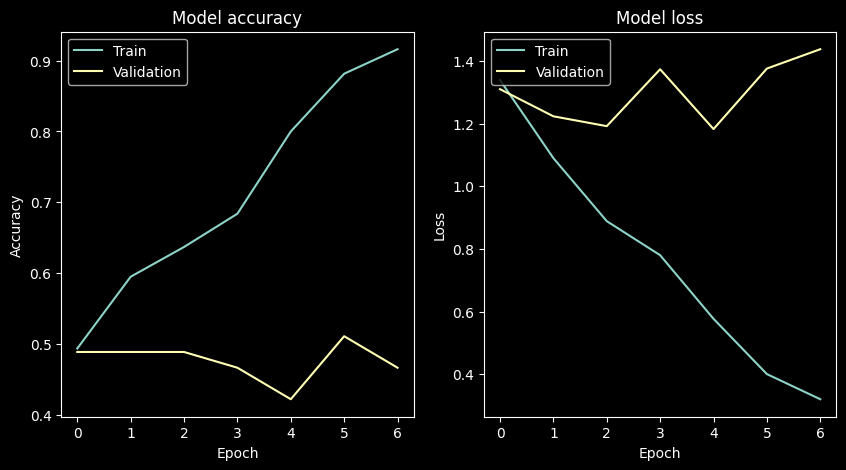

In [30]:
# Plot training & validation accuracy values
plt.suptitle("Losses and Metrics Plot", fontsize=15)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### Deployment

In [31]:
# Load the model and tokenizer
model = TFBertForSequenceClassification.from_pretrained('./fine-tuned-bert-amazon-reviews')
tokenizer = BertTokenizer.from_pretrained('./fine-tuned-bert-amazon-reviews')

Some layers from the model checkpoint at ./fine-tuned-bert-amazon-reviews were not used when initializing TFBertForSequenceClassification: ['dropout_115']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./fine-tuned-bert-amazon-reviews.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [41]:

def map_labels(label):
    if label == 0:
        return 'Very poor'
    elif label == 1:
        return 'Poor'
    elif label == 2:
        return 'Average'
    elif label == 3:
        return 'Good'
    elif label == 4:
        return 'Excellent'
    else:
        return 'Unknown'

def predict(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model(inputs)
    logits = outputs['logits'].numpy()
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_class = np.argmax(probabilities)
    sentiment = map_labels(predicted_class)
    predicted_probability = probabilities[predicted_class]
    return sentiment, predicted_probability

def on_button_click(button):
    clear_output(wait=True)
    sentiment, probability = predict(text_area.value)
    print(f"Prediction: {sentiment} with probability {probability:.4f}")
    display_ui()

def display_ui():
    display(text_area, button)

text_area = widgets.Textarea(
    value='',
    placeholder='Type your review here',
    description='Review:',
    disabled=False,
    layout=widgets.Layout(height='150px', width='80%')
)

button = widgets.Button(description="Predict")
button.on_click(on_button_click)

display_ui()


Prediction: Average with probability 0.3762


Textarea(value='its not good', description='Review:', layout=Layout(height='150px', width='80%'), placeholder=…

Button(description='Predict', style=ButtonStyle())

**Comparing both model**

From the comparison of the BERT and RoBERTa models based on the test loss and accuracy, we got few key insights.
1. Test Accuracy:
BERT Accuracy: 60.00%
RoBERTa Accuracy: 66.00%
Both models achieved the same accuracy on the test set, indicating that they performed equally well in terms of correctly classifying the test samples.

2. Test Loss:
BERT Test Loss: 1.064
RoBERTa Test Loss: 0.875
**The test loss for RoBERTa is lower than that of BERT. In the context of machine learning, a lower loss indicates that the model's predictions are closer to the true labels. This suggests that RoBERTa's predictions, while leading to the same accuracy, are more confident or better calibrated compared to BERT's.**